## Taxonomic occurrence data from OBIS

## Setup

In [ ]:
# Modify this section as needed.

# ==============================================================================
# === directory setup
# ==============================================================================
# If using google colab and google drive:
from google.colab import drive
drive.mount('/content/drive')

PROJECT_DIR = '/content/drive/MyDrive/GSoC_SDM_Project'

# === if using local machine
# PROJECT_DIR = './'
#import os
#if not os.path.exists(PROJECT_DIR):
#    os.makedirs(PROJECT_DIR)

# ==============================================================================
# ==============================================================================
# === spatial coverage
# ==============================================================================
LATMIN = 24.11637699635014
LATMAX = 26.11949526731449
LONMIN = -82.51572158798965
LONMAX = -79.61106009492724
# ==============================================================================

In [ ]:
try:
  import pyobis
except:
  %pip -q install pyobis
  import pyobis

try:
  import geoplot
except:
  %pip -q install geoplot
  import geoplot

try:
  import geopandas as gpd
except:
  %pip -q install geopandas
  import geopandas as gpd

try:
  import geodatasets
except:
  %pip -q install geodatasets
  import geodatasets


from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
%matplotlib inline

Mounted at /content/drive


## grabbing the data

Since our analysis will be highly dependent on the depth parameter, we will choose only non NaN values.

## Build a bounding box for Florida Keys

In [ ]:
import geopandas

In [ ]:
wkt = [f"POLYGON (({LONMIN} {LATMAX}, {LONMIN} {LATMIN}, {LONMAX} {LATMIN}, {LONMAX} {LATMAX}, {LONMIN} {LATMAX}))"]
gdf = geopandas.GeoSeries.from_wkt(wkt)

gdf

,0
0,"POLYGON ((-82.51572 26.1195, -82.51572 24.1163..."


In [ ]:
gdf.to_wkt()[0]

'POLYGON ((-82.515722 26.119495, -82.515722 24.116377, -79.61106 24.116377, -79.61106 26.119495, -82.515722 26.119495))'

In [ ]:

from pyobis import occurrences
import pandas as pd
import os


# define depth range
STARTDEPTH = 0
ENDDEPTH = 30
CACHE = True

# if occurrences file exists
if os.path.exists(f"{PROJECT_DIR}/occurrences.parquet") and CACHE:
    print('loading cached data from local system...')
    df = pd.read_parquet('occurrences.parquet')
else:
    # create empty df
    df = pd.DataFrame()
    # for taxa in seagrasses EOV aphiaID list
    # ref: https://github.com/ioos/marine_life_data_network/blob/main/eov_taxonomy/IdentifierList.csv
    seagrasses_ids = [143769, 143770, 143751, 143768, 234030]
    for taxa_id in seagrasses_ids:
        query = occurrences.search(taxonid=taxa_id, startdepth=STARTDEPTH, enddepth=ENDDEPTH, geometry=gdf.to_wkt()[0])
        df_taxa = query.execute()
        if len(df_taxa)<1:
            continue
        else:
            # select only the columns we need
            df_taxa = df_taxa[["decimalLatitude", "decimalLongitude", "occurrenceStatus", "date_year", "date_mid"]]
            df = pd.concat([df, df_taxa], ignore_index=True)


    # save df
    df.to_parquet(f'{PROJECT_DIR}/occurrences.parquet', engine='pyarrow', index=False)

print(df.head())



loading cached data from local system...
   decimalLatitude  decimalLongitude occurrenceStatus  date_year      date_mid
0        25.138383        -80.624983                Q     2006.0  1.147133e+12
1        24.996280        -80.649250                Q     2006.0  1.160006e+12
2        25.248783        -80.403150                Q     2005.0  1.115683e+12
3        25.252020        -80.397290                Q     2007.0  1.189469e+12
4        25.472200        -80.325950                Q     2005.0  1.129680e+12


## visualization

### 1. year-wise distribution
Let us see the year-wise distribution of records.

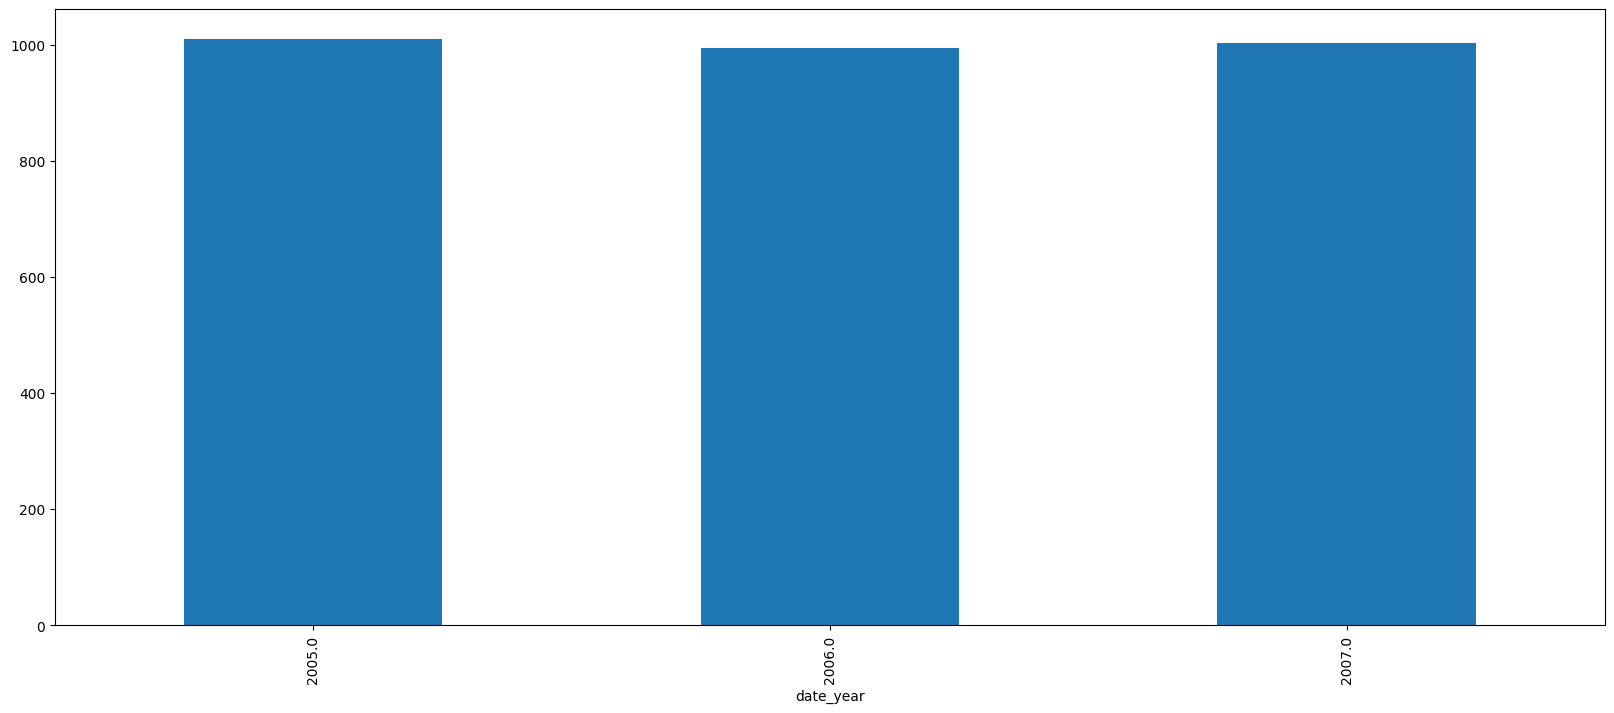

In [ ]:
df = pd.read_parquet('occurrences.parquet')

ax = df.groupby("date_year").date_mid.count().plot.bar(figsize = (20,8))

Patterns in the number of records through time are more likely due to sampling bias than changes in taxa population.

### with latitude and longitude stacked side-by-side

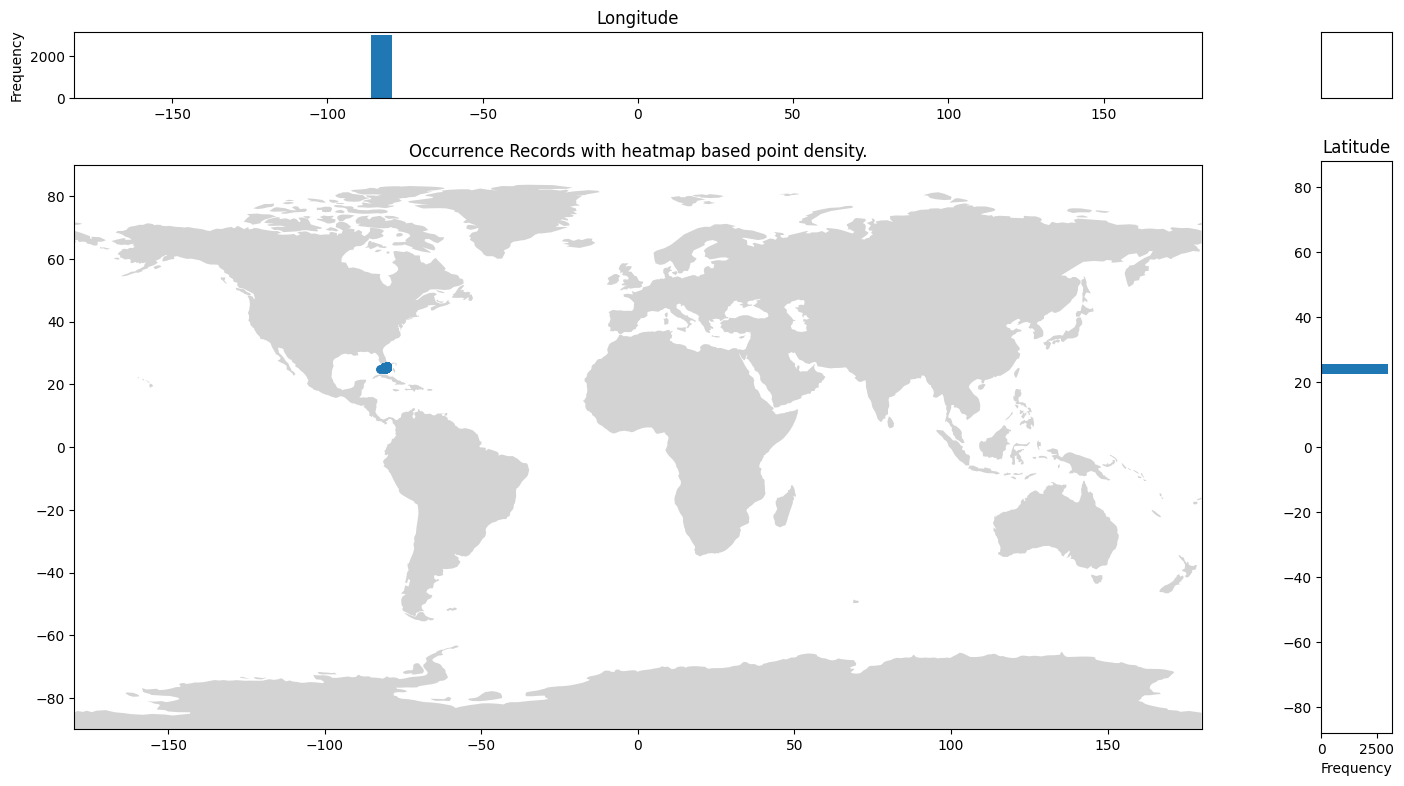

In [ ]:
import seaborn as sns
import geopandas as gpd
import geodatasets
import matplotlib.pyplot as plt

#df = pd.read_csv("data/occurrences.csv")

#getting the basemap
countries = gpd.read_file(geodatasets.get_path("naturalearth.land"))


f, axes = plt.subplots(
    2,
    2,
    figsize=(17,9.1),
    gridspec_kw={'width_ratios': [16, 1], 'height_ratios': [1, 8.7]}
)
df["decimalLongitude"].astype(int).plot.hist(
    ax=axes[0][0],
    bins=50,
    range=(-165, 165)  # manually adjusted (from 180) to better align with map
)
axes[0][0].set_title("Longitude")

axes[0][1].set_facecolor('white')
axes[0][1].tick_params(left=False, bottom=False, labelbottom=False, labelleft=False)

countries.plot(color="lightgrey", figsize=(16, 8.4), ax = axes[1][0])
sns.scatterplot(
    data=df,
    x="decimalLongitude",
    y="decimalLatitude",
    linewidth=0,
    ax=axes[1][0]
)

axes[1][0].set_xlim(-180,180)
axes[1][0].set_ylim(-90, 90)
axes[1][0].set_title("Occurrence Records with heatmap based point density.")
axes[1][0].set_xlabel("")
axes[1][0].set_ylabel("")
df["decimalLatitude"].astype(int).plot.hist(
    orientation='horizontal',
    ax=axes[1][1],
    bins=50,
    range=(-80, 80)
)

axes[1][1].set_title("Latitude")
plt.show()

In [ ]:
import plotly.express as px


# Create a scatter plot on a map
fig = px.scatter_geo(
    df,
    lat='decimalLatitude',
    lon='decimalLongitude',
    #hover_name='station',
    projection='natural earth',
    title='Points on a Map',
    scope='north america',
)
fig.show()

--------------------
--------------------